In [315]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import time
import sys

full_index0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
strip_index = [0, 5, 4, 3, 2, 1, 12, 11, 10, 9, 8, 7, 18, 17, 16, 15, 45, 44, 55, 54, 53, 52, 51, 50, 61, 60, 59, 58, 57, 56, 36, 31, 6, 25, 26, 27, 28, 29, 30, 19, 20, 21, 22, 23, 24, 13, 14, 46, 47, 48, 49, 38, 39, 40, 41, 42, 43, 32, 33, 34, 35, 37, 62, 63]

index_original = np.array(full_index0)
index_strip    = np.array(strip_index)

class LAPPD:
    def __init__(self, data, pedestals) -> None:
        self.data = data
        self.pedestals = pedestals
        #self.options = options
        self.event_data = self.load_data()

    def load_file(self, file_input):
        # Read the event data into a pandas DataFrame
        return pd.read_csv(file_input, sep=' ', header=None)
    
    def load_data(self):
        data = self.load_file(self.data)

        # Assuming each event contains 256 lines
        lines_per_event = 256

        # Calculate the number of events
        num_events = len(data) // lines_per_event

        # Reshape the event data to have one row per event
        return data.values.reshape((num_events, lines_per_event, -1))
    
    def get_events(self):
        return self.event_data
    
    def PedestalSubtraction(self):
        pedestal1 = self.load_file(self.pedestals[0]) 
        pedestal2 = self.load_file(self.pedestals[1]) 
       
        # reshape the pedestal data to match the shape of the event data
        pedestal1_values = pedestal1.values.reshape(1, -1, 30).astype(float)
        pedestal2_values = pedestal2.values.reshape(1, -1, 30).astype(float)

        self.event_data[:, :, 1:31] -= pedestal1_values
        self.event_data[:, :, 32:62] -= pedestal2_values
        print("Done Pedestal Substraction")

       #return self.event_data 

    def ADC2Voltage(self):
        # Multiply by 0.3 to convert ADC to Voltage
        # -1 to 0.3 is to invert the waveforms
        self.event_data[:, :, 1:31]  = np.multiply(self.event_data[:, :, 1:31],-0.3) 
        self.event_data[:, :, 32:62] = np.multiply(self.event_data[:, :, 32:62],-0.3)
        #return self.event_data
        print("Done Converting to Voltage")

    def ACDCmetaCorrection(self):
        # Reorder ACDC meta 
        num_events = self.event_data.shape[0]

        bs1 = int("0000000000000111", 2)
        shift_values = np.array([bs1 & int(x, 16) for x in self.event_data[:,10,31]])
        shift_values = np.multiply(shift_values, 32)

        shift_global = np.full(num_events, 80)

        # Create a range of indices along the rows axis
        row_indices = np.arange(self.event_data.shape[1])
        # Expand the meta array to match the shape of event_data along the rows axis
        expanded_meta = np.expand_dims(-shift_values, axis=1)
        # Calculate the rolled indices using broadcasting
        rolled_indices = (row_indices - expanded_meta) % self.event_data.shape[1]
        # Use advanced indexing to roll the event_data array
        self.event_data = self.event_data[np.arange(len(-shift_values))[:, None], rolled_indices]

        # Shift 80 time units (Matt?)
        # Expand the meta array to match the shape of event_data along the rows axis
        expanded_meta = np.expand_dims(-shift_global, axis=1)
        # Calculate the rolled indices using broadcasting
        rolled_indices = (row_indices - expanded_meta) % self.event_data.shape[1]
        # Use advanced indexing to roll the event_data array
        self.event_data = self.event_data[np.arange(len(-shift_global))[:, None], rolled_indices]
        #return self.event_data
        print("Done Metadata correction")

    def ACDC2Strip(self):
        # --------------------------------------------------------------------------------------------------
        # ACDC channels index to Strip index
        self.event_data = self.event_data[:, :, strip_index]
        print("Done mapping ACDC to Strip") 

    def BaselineCorrection(self):
        # --------------------------------------------------------------------------------------------------
        # Baseline correction
        # ToDo: Arbitrary it is set the mean from 200ns to 220ns
        # Calculate the baseline for each row
        #baseline1 = np.mean(event_data[:,0:255,1:31], axis=1, keepdims=True)
        #baseline1 = np.mean(self.event_data[:,100:120,1:31], axis=1, keepdims=True)
        baseline1 = np.mean(self.event_data[:,150:180,1:31], axis=1, keepdims=True)
        self.event_data[:, :, 1:31] -= baseline1 

        #baseline2 = np.mean(event_data[:,0:255,32:62], axis=1, keepdims=True)
        #baseline2 = np.mean(self.event_data[:,100:120,32:62], axis=1, keepdims=True)
        baseline2 = np.mean(self.event_data[:,150:180,32:62], axis=1, keepdims=True)
        self.event_data[:, :, 32:62] -= baseline2
        print("Done Baseline Substraction")


    def FFT(self, cutoff_frequency=50):
        sampling_rate = 256  # Adjust according to your actual sampling rate
        #cutoff_frequency = 50  # Cutoff frequency in Hz
        filtered_waveforms1 = np.zeros_like(self.event_data[:, :, 1:31])
        filtered_waveforms2 = np.zeros_like(self.event_data[:, :, 32:62])

        for i in range(self.event_data[:, :, 1:31].shape[0] - 2):
            for j in range(self.event_data[:, :, 1:31].shape[2]):
                ct = i + 1
                cj = j + 1

                waveform = np.array(self.event_data[ct:ct+1, :, cj:cj+1],dtype=float).flatten()

                if len(waveform) == 0:
                    print(ct,":",ct+1," waveform is empty. Cannot perform FFT.", cj,":",cj+1)
                else:
                    fft_result = np.fft.fft(waveform)

                # Create the filter
                freqs = np.fft.fftfreq(len(waveform), d=1/sampling_rate)
                filter_mask = np.abs(freqs) < cutoff_frequency

                # Apply the filter
                filtered_fft_result = fft_result * filter_mask

                # Inverse FFT to get back to time domain
                filtered_waveform = np.fft.ifft(filtered_fft_result)

                # Store the filtered waveform
                filtered_waveforms1[i, :, j] = filtered_waveform.real

        
        for i in range(self.event_data[:, :, 32:62].shape[0] - 2):
            for j in range(self.event_data[:, :, 32:62].shape[2]):
                ct = i + 1
                cj = 31 + j + 1

                waveform = np.array(self.event_data[ct:ct+1, :, cj:cj+1],dtype=float).flatten()

                if len(waveform) == 0:
                    print(ct,":",ct+1," waveform is empty. Cannot perform FFT.", cj,":",cj+1)
                else:
                    fft_result = np.fft.fft(waveform)

                # Create the filter
                freqs = np.fft.fftfreq(len(waveform), d=1/sampling_rate)
                filter_mask = np.abs(freqs) < cutoff_frequency

                # Apply the filter
                filtered_fft_result = fft_result * filter_mask

                # Inverse FFT to get back to time domain
                filtered_waveform = np.fft.ifft(filtered_fft_result)

                # Store the filtered waveform
                filtered_waveforms2[i, :, j] = filtered_waveform.real
        
        self.event_data[:, :, 1:31] = filtered_waveforms1
        self.event_data[:, :, 32:62] = filtered_waveforms2
        print(f"Done FFT with cutoff_frequency of {cutoff_frequency}")

    
    #---------------------- plotting stuff -----------------------------------------------------------------
    
    def get_event(self, event_id, side, spare_channels):
        if side == 0:
            if spare_channels == 0:
                return self.event_data[event_id,:,2:30]
            else:
                return self.event_data[event_id,:,1:31]
        else:
            if spare_channels == 0:
                return self.event_data[event_id,:,33:61] 
            else:
                return self.event_data[event_id,:,32:62]

    def plot2D_event(self, event_id, side, spare_channels):
        plt.imshow(self.get_event(event_id, side, spare_channels).astype(float).T,cmap='viridis', aspect='auto')
        plt.colorbar(label='Amplitude [mV]')  # Add colorbar for reference
        plt.gca().invert_yaxis()
        plt.title("Event {}, side {}".format(event_id, side))
        plt.xlabel('Time [ns]')
        if spare_channels == 0:
            plt.ylabel('Strip #')
        else:
            plt.ylabel('Strip # + spare channels')
        plt.show()

    def plot1D_event(self, event_id, side, spare_channels):
        plt.plot(self.get_event(event_id, side, spare_channels))
        if spare_channels == 0:
            plt.title('Projetion Event {}, side {}'.format(event_id, side))
        else:
            plt.title('Projetion Event {}, side {}, + spare channels'.format(event_id, side))
        plt.xlabel('Time [ns]')
        plt.ylabel('Amplitude [mV]')
        plt.show()

    def plot2D_eventAx(self, event_id, side, spare_channels, ax):
        im = ax.imshow(self.get_event(event_id, side, spare_channels).astype(float).T,cmap='viridis', aspect='auto')
        plt.colorbar(im, ax=ax).set_label('Amplitude [mV]')  # Add colorbar for reference
        ax.invert_yaxis()
        ax.set_title("Side {}".format(side))
        ax.set_xlabel('Time [ns]')
        if spare_channels == 0:
            ax.set_ylabel('Strip #')
        else:
            ax.set_ylabel('Strip # + spare channels')

    def plot1D_eventAx(self, event_id, side, spare_channels, ax):
        ax.plot(self.get_event(event_id, side, spare_channels))
        if spare_channels == 0:
            ax.set_title('Projetion , side {}'.format(side))
        else:
            ax.set_title('Projetion, side {}, + spare channels'.format(side))
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Amplitude [mV]')

    def display_event(self, event_id, spare_channels, show_display):
        plt.style.use(['dark_background'])
        if show_display == 0:
            plt.switch_backend('Agg')

        # Create a figure and subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9))
        
        # Plot data on each subplot
        self.plot2D_eventAx(event_id, 0, spare_channels, ax1)
        self.plot2D_eventAx(event_id, 1, spare_channels, ax2)
        self.plot1D_eventAx(event_id, 0, spare_channels, ax3)
        self.plot1D_eventAx(event_id, 1, spare_channels, ax4)

        # Add a general title to the canvas
        fig.suptitle("Event {}".format(event_id), fontsize=16)

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        if show_display == 1:
            plt.show()
        
        plt.close()
        return fig

    def Display_eventsPDF(self, spare_chn, nevent, output_name):
        print("Plotting the events....")
        # Create a PDF file to save the plots
        plt.switch_backend('Agg')
        with PdfPages(output_name+".pdf") as pdf:
            # Initialize the progress bar
            progress_bar = tqdm(total=nevent, desc="Progress", unit="iteration")
            for i in range(nevent):
                fig = self.display_event(i, spare_chn, 0)
                pdf.savefig(fig)
                progress_bar.update(1)
            progress_bar.close()
            print("Plotting done....")


In [317]:
    nevents  =  1
    #datapath  = '/Users/mascenci/Desktop/annie/lappd/data/lappd39/Ascii20230307_122317.txt'
    #datapath  = '/Users/mascenci/Desktop/annie/lappd/data/lappd39/Ascii20230307_133429.txt'
    #datapath  = '/Users/mascenci/Desktop/annie/lappd/data/lappd151/Ascii20242707_115156.txt'
    datapath  = '/Users/mascenci/Desktop/annie/lappd/data/lappd151/Ascii20242707_130117.txt'
    ped1      = '/Users/mascenci/Desktop/annie/lappd/data/lappd151/P0.txt'
    ped2      = '/Users/mascenci/Desktop/annie/lappd/data/lappd151/P1.txt'
    #ped1      = '/Users/mascenci/Desktop/annie/lappd/data/lappd39/ACDC26_needCheck.txt'
    #ped2      = '/Users/mascenci/Desktop/annie/lappd/data/lappd39/ACDC31_needCheck.txt'
    pedestals = [ped1, ped2]
    output   = '/Users/mascenci/Desktop/annie/lappd/output/Event_display'

Done Pedestal Substraction
Done Converting to Voltage
Done Metadata correction
Done mapping ACDC to Strip
Done Baseline Substraction
Done FFT with cutoff_frequency of 20


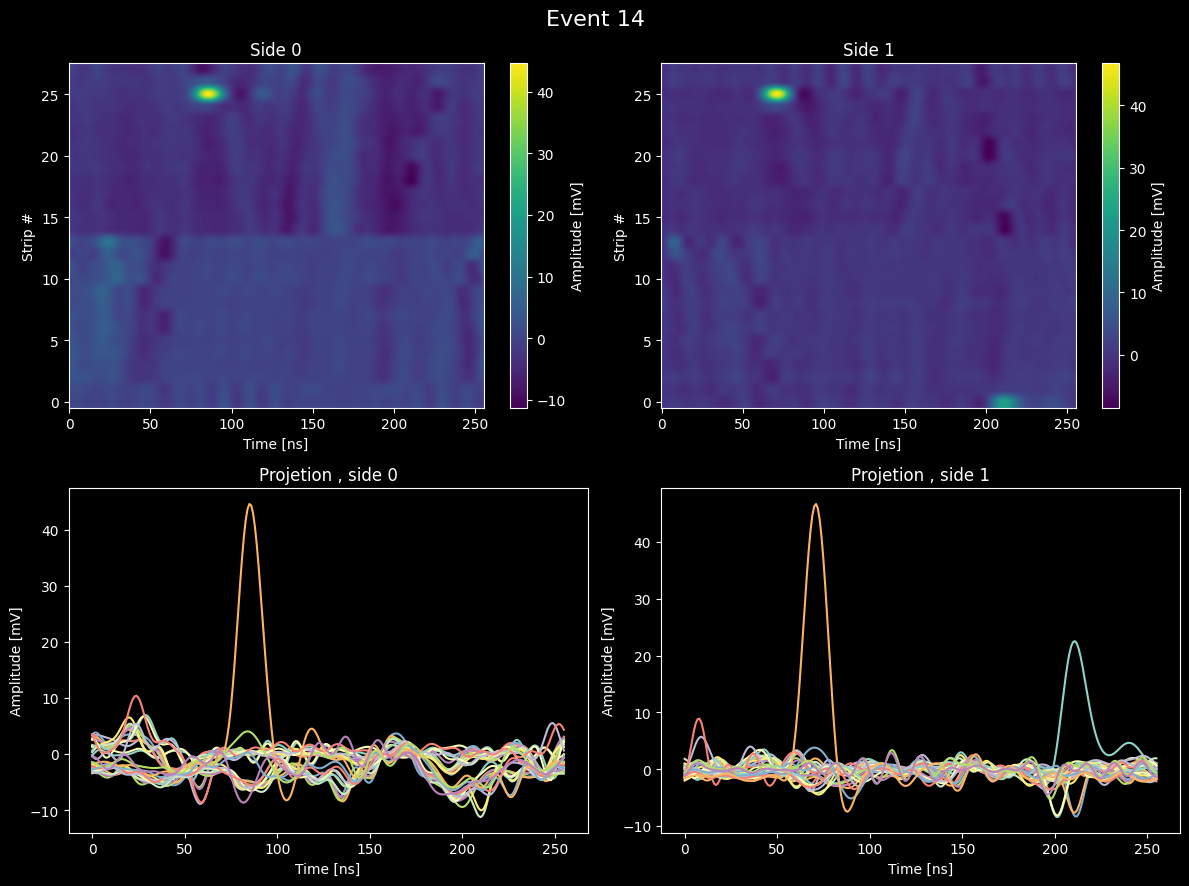

In [318]:
lappd = LAPPD(datapath, pedestals)
lappd.PedestalSubtraction()
lappd.ADC2Voltage()
lappd.ACDCmetaCorrection()
lappd.ACDC2Strip()
lappd.BaselineCorrection()
lappd.FFT(cutoff_frequency=20)

#lappd.display_event(342, 1, 0)
lappd.display_event(14, 0, 0)

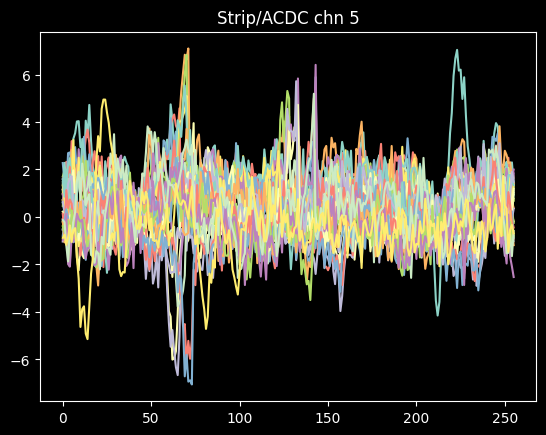

In [141]:
event_data = lappd.get_events()
%matplotlib inline
plt.style.use(['dark_background'])
for i in range(30):
    plt.plot(event_data[50,:,i+1])
plt.title(f'Strip/ACDC chn {5}')
plt.show()

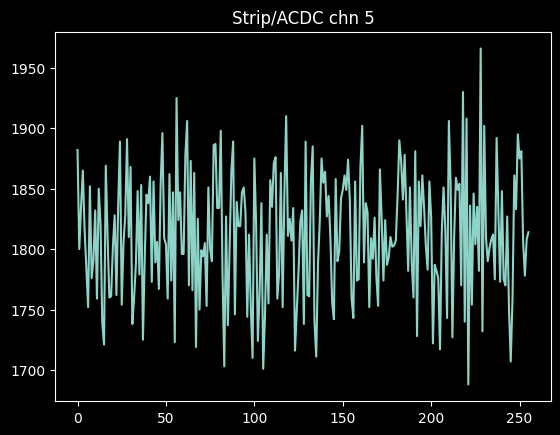

In [85]:
plt.plot(event_data[50,:,5].T)
plt.style.use(['dark_background'])
plt.title(f'Strip/ACDC chn {5}')
plt.show()


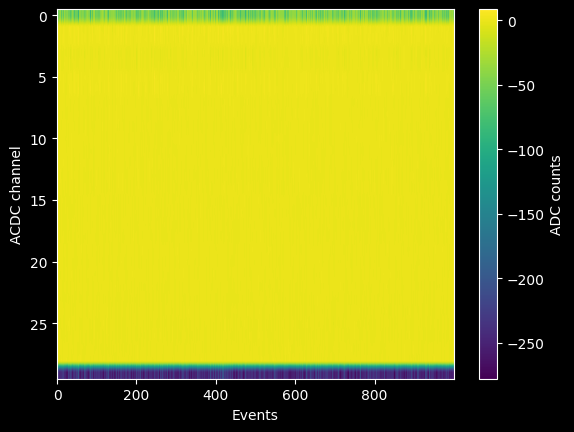

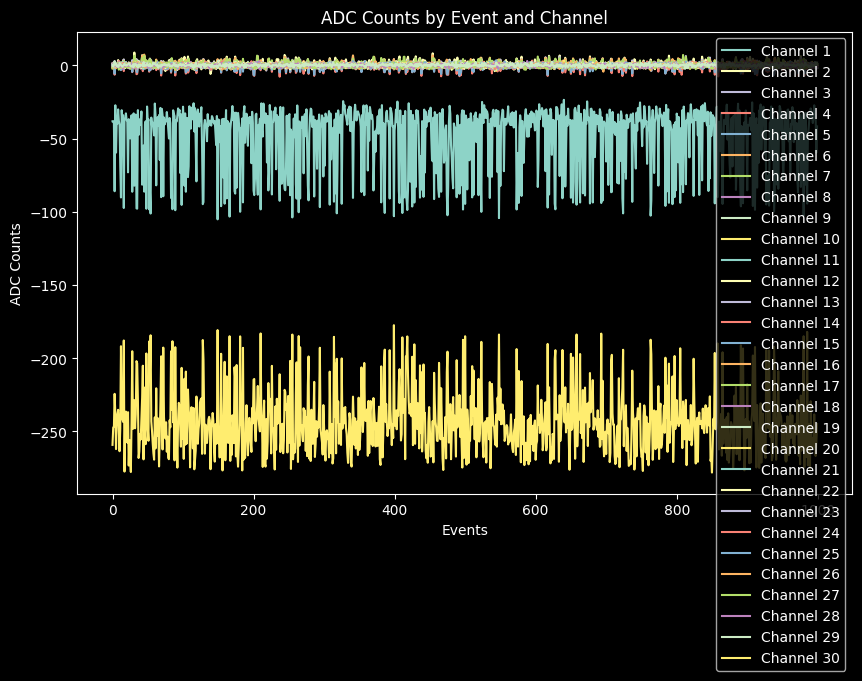

In [142]:
nev=1000
evnt = np.zeros((nev, 30))
#print(evnt)
for j in range(0,nev):
    evnti = np.zeros((1,30))
    for i in range(0,30):
        evnti[:, i] = (event_data[j,100:101,i+32]) #i+1
    evnt[j,:] = evnti

evnt_array = np.array(evnt)
plt.style.use(['dark_background'])

plt.imshow(evnt.T, cmap='viridis', aspect='auto')
plt.colorbar().set_label('ADC counts')
plt.xlabel('Events')
plt.ylabel('ACDC channel')
#plt.title(f'Strip/ACDC chn {5}')
plt.show()

plt.figure(figsize=(10, 6))

# Plot each channel with a different color
for channel in range(evnt_array.shape[1]):
    plt.plot(range(evnt_array.shape[0]), evnt_array[:, channel], label=f'Channel {channel + 1}')

# Set the labels and title
plt.xlabel('Events')
plt.ylabel('ADC Counts')
plt.title('ADC Counts by Event and Channel')
#plt.xticks(range(evnt_array.shape[0]), [f' {i + 1}' for i in range(evnt_array.shape[0])])
plt.legend()

plt.savefig('plot.png', transparent=True)
# Show the plot
plt.show()

In [2]:
'''
for ts in range(256):
    nev=1000
    evnt = np.zeros((nev, 30))
    #print(evnt)
    for j in range(0,nev):
        evnti = np.zeros((1,30))
        for i in range(0,30):
            evnti[:, i] = (event_data[j,ts:ts+1,i+32]) #i+1
        evnt[j,:] = evnti

    evnt_array = np.array(evnt)
    plt.style.use(['dark_background'])
    plt.imshow(evnt.T, cmap='viridis', aspect='auto')
    plt.colorbar().set_label('ADC counts')
    plt.xlabel('Events')
    plt.ylabel('ACDC channel')
    #plt.title(f'Strip/ACDC chn {5}')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    
    # Plot each channel with a different color
    for channel in range(evnt_array.shape[1]):
        plt.plot(range(evnt_array.shape[0]), evnt_array[:, channel], label=f'Channel {channel + 1}')
    
    # Set the labels and title
    plt.xlabel('Events')
    plt.ylabel('ADC Counts')
    plt.title(f'ADC Counts by Event and Channel, ts {ts}')
    #plt.xticks(range(evnt_array.shape[0]), [f' {i + 1}' for i in range(evnt_array.shape[0])])
    plt.legend()
    
    # Show the plot
    plt.show()
'''

"\nfor ts in range(256):\n    nev=1000\n    evnt = np.zeros((nev, 30))\n    #print(evnt)\n    for j in range(0,nev):\n        evnti = np.zeros((1,30))\n        for i in range(0,30):\n            evnti[:, i] = (event_data[j,ts:ts+1,i+32]) #i+1\n        evnt[j,:] = evnti\n\n    evnt_array = np.array(evnt)\n    plt.style.use(['dark_background'])\n    plt.imshow(evnt.T, cmap='viridis', aspect='auto')\n    plt.colorbar().set_label('ADC counts')\n    plt.xlabel('Events')\n    plt.ylabel('ACDC channel')\n    #plt.title(f'Strip/ACDC chn {5}')\n    plt.show()\n    \n    plt.figure(figsize=(10, 6))\n    \n    # Plot each channel with a different color\n    for channel in range(evnt_array.shape[1]):\n        plt.plot(range(evnt_array.shape[0]), evnt_array[:, channel], label=f'Channel {channel + 1}')\n    \n    # Set the labels and title\n    plt.xlabel('Events')\n    plt.ylabel('ADC Counts')\n    plt.title(f'ADC Counts by Event and Channel, ts {ts}')\n    #plt.xticks(range(evnt_array.shape[0]), [